In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
import pandas as pd
from fastdtw import fastdtw

In [49]:
cpu_ts = pd.read_csv('./managed_cluster_cpu_04_24_30_15_min.csv')

In [206]:
sample_df = cpu_ts.set_index('timestamp')

In [50]:
cpu_ts.timestamp = pd.to_datetime(cpu_ts.timestamp, infer_datetime_format=True)  

In [208]:
sample_df['ts_length'] = sample_df.groupby('cluster_id')['cluster_id'].transform(len)

In [209]:
sample_df = sample_df.loc[sample_df['ts_length'] == 360]

There are 376 different clusters

In [75]:
len(sample_df.groupby('cluster_id')['cluster_id'].unique())

376

In [51]:
cpu_ts.timestamp.dt.day.unique()

array([24, 29, 30, 25])

In [80]:
for cluster_id, df in sample_df.groupby('cluster_id'):
    print(df[(df.index.hour >= 18) | (df.index.hour <= 5)].head())
    break

                     Cpu_usage                            cluster_id  \
timestamp                                                              
2022-04-24 00:00:00  26.011429  01a754f2-8cdb-4f28-b2e1-8fe592d5c1e1   
2022-04-24 00:15:00  27.445619  01a754f2-8cdb-4f28-b2e1-8fe592d5c1e1   
2022-04-24 00:30:00  23.414618  01a754f2-8cdb-4f28-b2e1-8fe592d5c1e1   
2022-04-24 00:45:00  24.345648  01a754f2-8cdb-4f28-b2e1-8fe592d5c1e1   
2022-04-24 01:00:00  27.690381  01a754f2-8cdb-4f28-b2e1-8fe592d5c1e1   

                     ts_length  
timestamp                       
2022-04-24 00:00:00        360  
2022-04-24 00:15:00        360  
2022-04-24 00:30:00        360  
2022-04-24 00:45:00        360  
2022-04-24 01:00:00        360  


In [54]:
cpu_ts['count'] = cpu_ts.groupby('cluster_id')['cluster_id'].transform('count')

In [55]:
sample_df = cpu_ts.copy(deep=True)

In [61]:
sample_df = sample_df.loc[sample_df['count']==360]

In [63]:
sample_df.drop(columns=['count'],inplace=True)

/var/folders/bd/srftq4bj7r90mhbkt_4lfx880000gn/T/ipykernel_22267/189082364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df.drop(columns=['count'],inplace=True)


In [66]:
sample_df.set_index('timestamp',inplace=True)

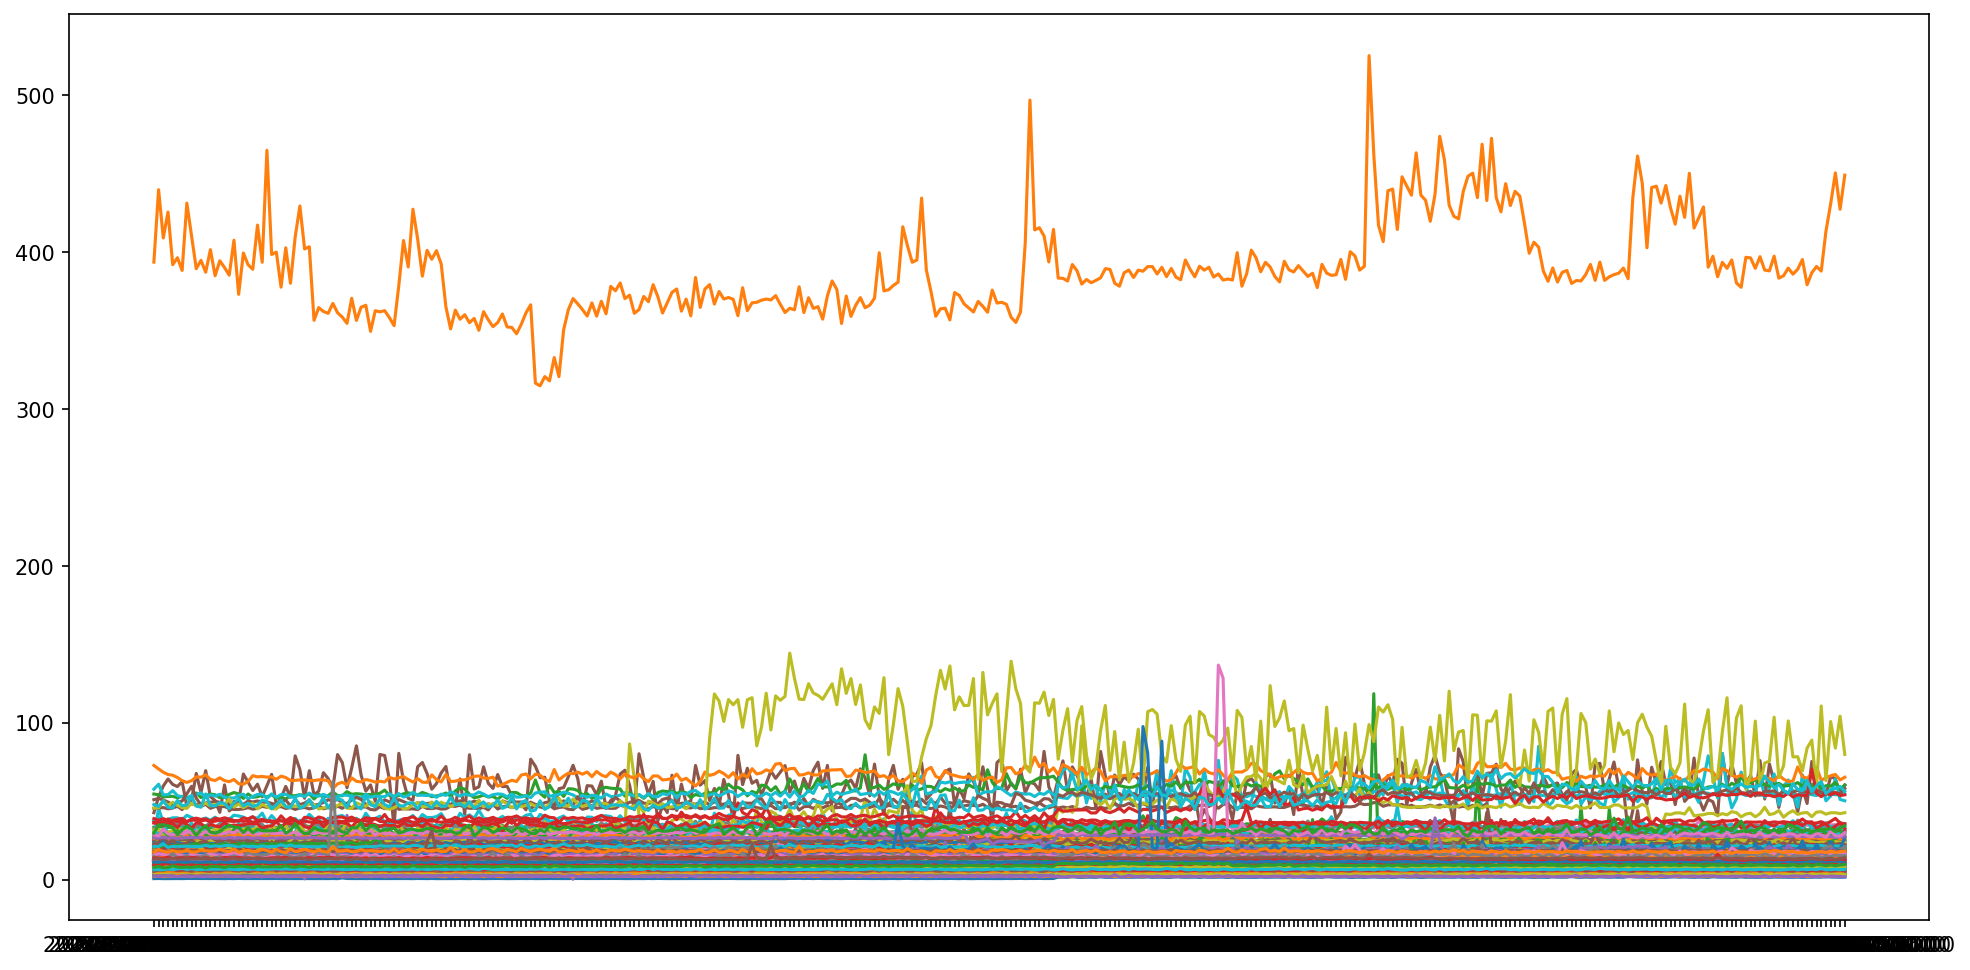

In [293]:
plt.figure(figsize=(16, 8), dpi=150)
#sample_size = 15
count = 0
for cluster_id, df in sample_df.groupby('cluster_id'):
    plt.plot(df.index,df['Cpu_usage'],label='line')
    # if count == sample_size:
    #     break
    # df['Cpu_usage'].plot(legend="!@#")
    count += 1 
plt.show()

In [36]:
sample_df.drop(columns=['ts_length'],inplace=True)

In [19]:
sample_df.shape

(135360, 1)

In [72]:
from sklearn.preprocessing import OneHotEncoder

In [172]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(sample_df['cluster_id'].values.reshape(1,-1))

OneHotEncoder(handle_unknown='ignore')

In [183]:
cluster_id_map = {cluster_id:index for index, cluster_id in enumerate(sample_df['cluster_id'].unique())}

In [57]:
from tslearn.generators import random_walks

In [70]:
X = random_walks(n_ts=2,sz=3,d=2)

In [71]:
seed = 42
rng = np.random.RandomState(42)

In [87]:
seed

0

In [67]:
df_copy = sample_df.copy(deep=True)

To Flatten the current data by cluster_id to have the dimensions as (# of clusters, Timeseries size, dimensions)

In [68]:
g = df_copy.groupby('cluster_id').cumcount()
L = (df_copy.set_index(['cluster_id',g])
       .unstack(fill_value=0)
       .stack().groupby(level=0)
       .apply(lambda x: x.values.tolist())
       .tolist())

In [69]:
np_arrap = np.array(L)

In [70]:
np_arrap.shape

(376, 360, 1)

In [193]:
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
# Make time series shorter
X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
sz = X_train.shape[1]

In [200]:
X_train.shape

(50, 40, 1)

With the distance Metric Euclidean and K value 3

In [80]:
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred_euc = km.fit_predict(np_arrap)

25081.566 --> 20010.186 --> 18419.950 --> 17227.302 --> 16599.483 --> 15801.445 --> 15377.342 --> 14762.996 --> 14614.289 --> 14567.382 --> 14502.430 --> 14440.636 --> 14430.840 --> 14430.840 --> 


With the distance Metric as DTW and the K value of 3

In [73]:
dba_km = TimeSeriesKMeans(n_clusters=3, n_init=3, metric="dtw",verbose=True,
                          random_state=rng)
y_pred = dba_km.fit_predict(np_arrap)

Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


20478.590 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


9475.979 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8916.666 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8431.001 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


8307.928 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7738.812 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7573.726 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7515.431 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7512.108 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7512.108 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


31703.946 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7734.667 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7518.609 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7471.132 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7471.132 --> 
Init 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


13331.233 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


7306.445 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


7287.882 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7282.708 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7282.708 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


In [ ]:
dba_km = TimeSeriesKMeans(n_clusters=3, n_init=3, metric="softdtw",verbose=True,
                          random_state=rng)
y_pred = dba_km.fit_predict(np_arrap)

In [96]:
dba_km.cluster_centers_.shape

(3, 360, 1)

In [93]:
km.cluster_centers_.shape

(3, 360, 1)

The background plots are the actual time series plots of the clusters, where as the red plot signifies the cluster centroids of kmeans algorithm.

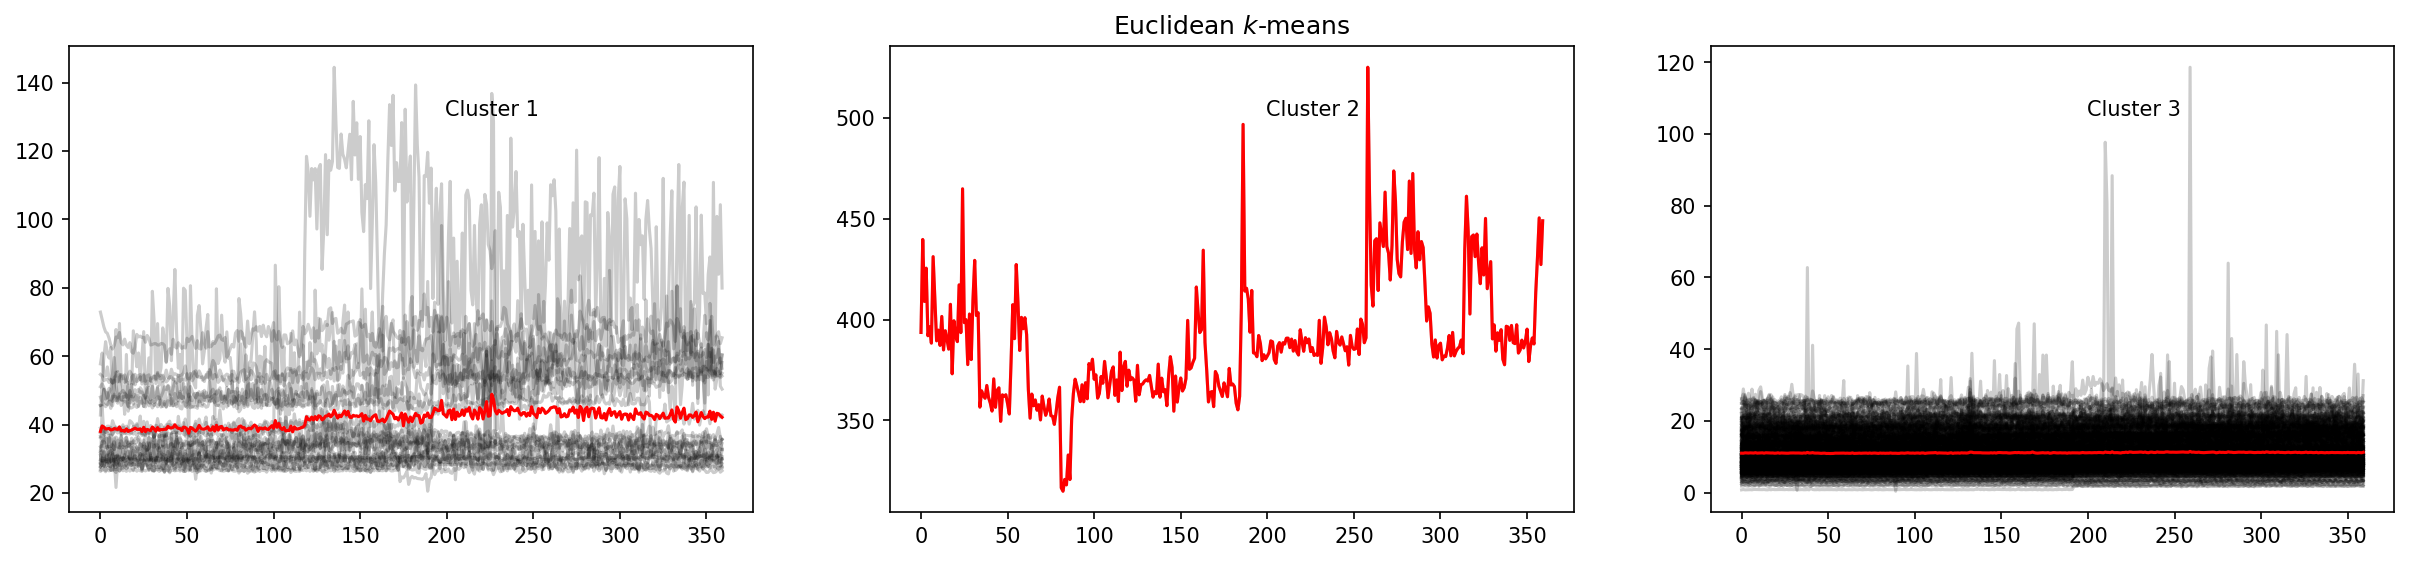

In [81]:
plt.figure(figsize=(20, 14), dpi=150)
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in np_arrap[y_pred_euc == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    # plt.xlim(0, sz)
    # plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")


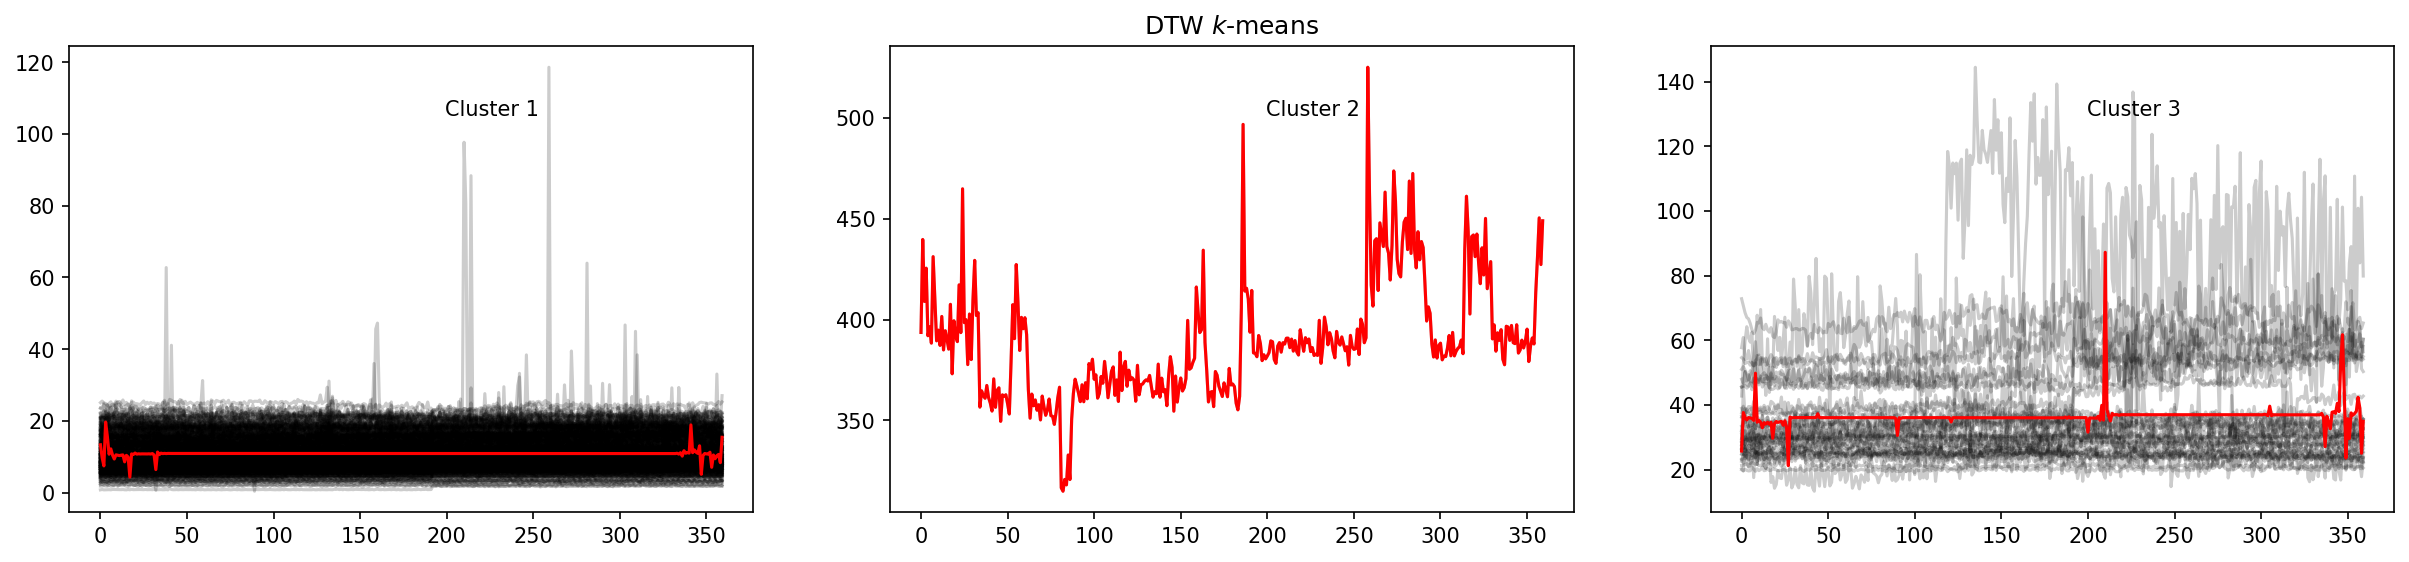

In [79]:
plt.figure(figsize=(20, 14), dpi=150)
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for cluster in np_arrap[y_pred == yi]:
        plt.plot(cluster.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    # plt.xlim(0, sz)
    # plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

In [220]:
np.where(y_pred == 1)

(array([351]),)

In [83]:
anomaly = np_arrap[351].reshape(360,)

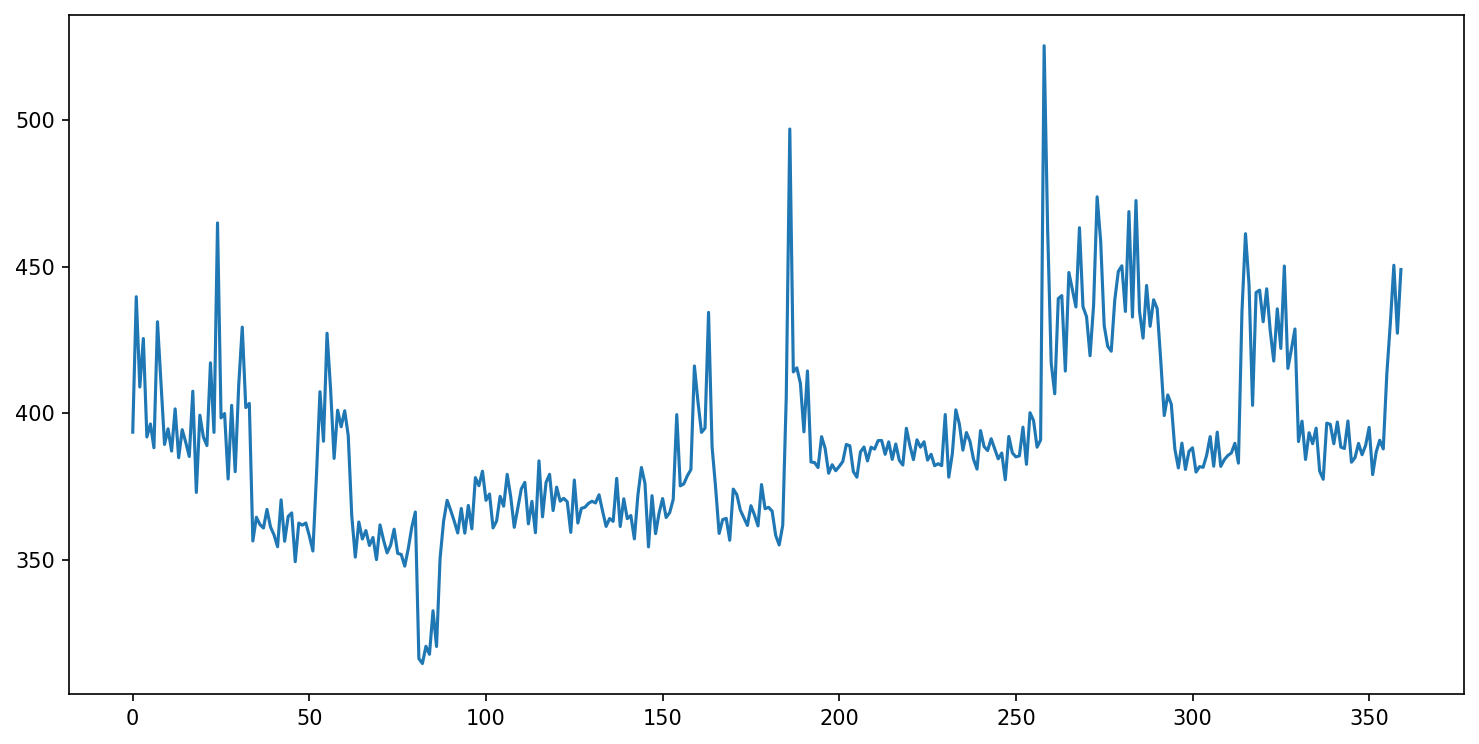

In [88]:
plt.figure(figsize=(12, 6), dpi=150)
plt.plot(anomaly)

In [89]:
dba_sfdtw = TimeSeriesKMeans(n_clusters=3, n_init=3, metric="softdtw",verbose=True,
                          random_state=rng)
y_pred_sdtw = dba_km.fit_predict(np_arrap)

Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


16726.535 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


9240.665 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8133.994 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7700.479 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7423.673 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7389.903 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7389.903 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


18603.578 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


9316.498 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8566.477 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8184.817 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7915.070 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7726.798 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7717.958 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


7715.662 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7715.662 --> 
Init 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.4s finished


14297.915 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7862.987 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    3.5s finished


7764.734 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7603.384 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


7417.610 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.5s finished


7410.897 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7410.897 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


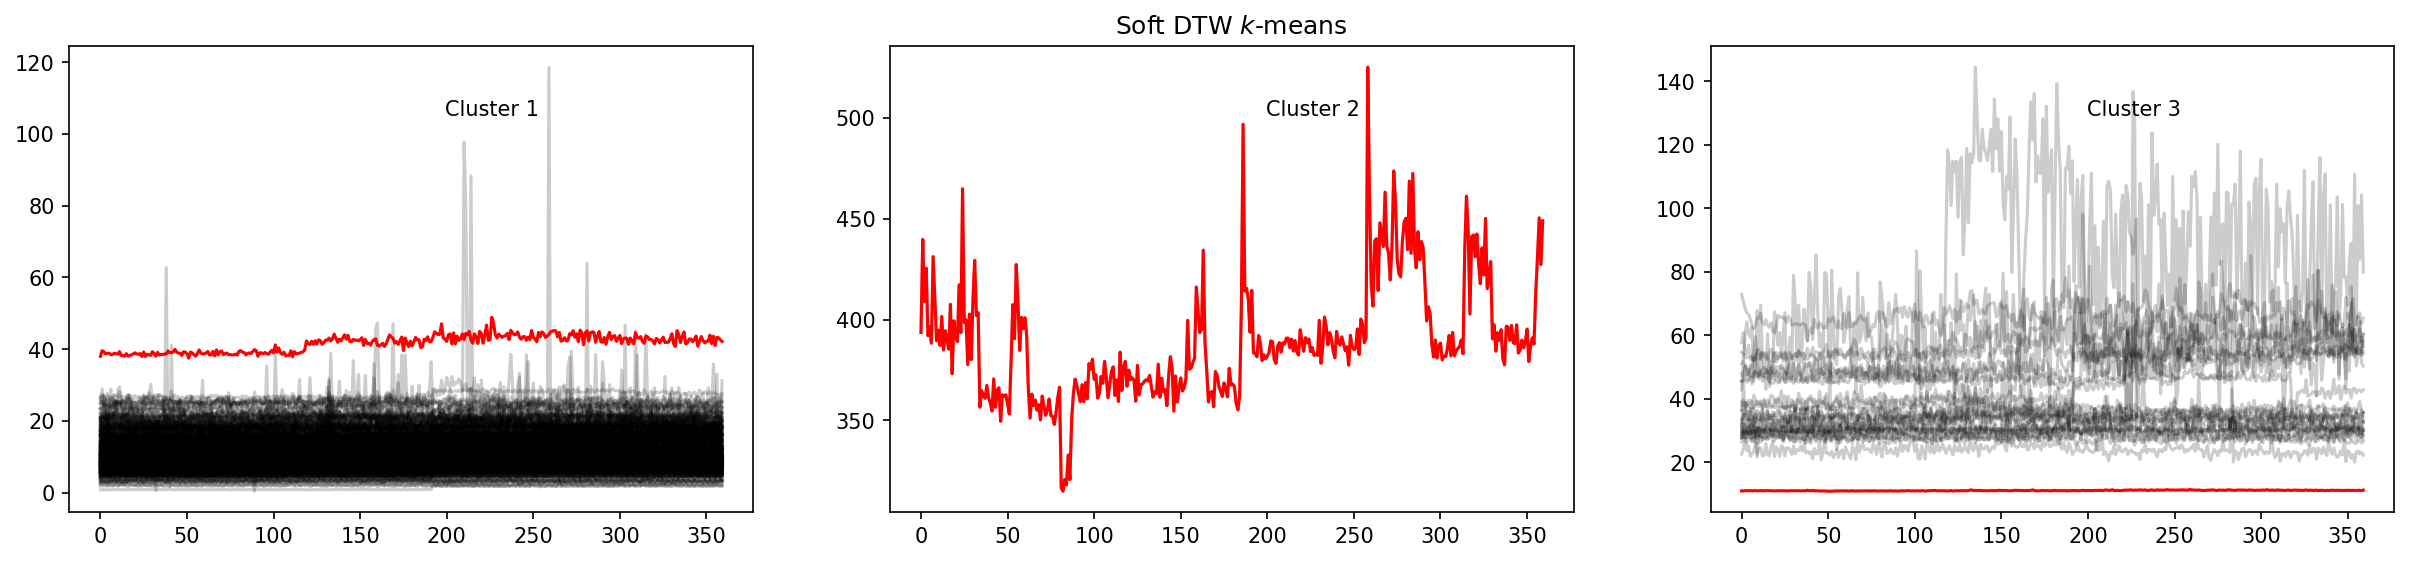

In [90]:
plt.figure(figsize=(20, 14), dpi=150)
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in np_arrap[y_pred_sdtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    # plt.xlim(0, sz)
    # plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft DTW $k$-means")

In [180]:
from pandas import Series

In [168]:
cluster_output_df

,k,Silohoutte_score
0,1,2
1,1,2
2,1,2
3,1,2


In [186]:
from tslearn.clustering import silhouette_score
clusters = [3,4,5,6,7,8]
output = []
for k in clusters:
    dba_km = TimeSeriesKMeans(n_clusters=3, n_init=3, metric="dtw",verbose=True,
                          random_state=rng)
    y_pred = dba_km.fit_predict(np_arrap)
    sil_score = silhouette_score(X, y_pred, metric="dtw")
    output.append([k,sil_score])
cluster_output_df = pd.DataFrame(output,columns=['k','Silohoutte_score'])

Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


18702.365 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7548.627 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7537.708 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7537.708 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


15928.135 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8235.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7713.239 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.4s finished


7465.565 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


7425.528 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7425.528 --> 
Init 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


30072.234 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


10552.654 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


9429.400 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


8804.495 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8432.092 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8294.682 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7668.874 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7517.161 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7502.803 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7496.857 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7485.398 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7467.230 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7467.230 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


14081.865 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7389.486 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7294.439 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7293.199 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7293.199 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


16934.466 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8238.743 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7981.134 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7755.079 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7607.820 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


7588.364 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7588.364 --> 
Init 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


11955.713 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7596.888 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7572.480 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7568.078 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7568.078 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


17780.394 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8474.691 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8055.727 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7831.150 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7612.268 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7579.620 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7578.665 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


7578.665 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    2.3s finished


15863.317 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7401.909 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7383.852 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7383.826 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7383.826 --> 
Init 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


18950.758 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


9286.674 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


8779.548 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8498.621 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


8369.718 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.6s finished


7682.454 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


7618.420 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.6s finished


7612.482 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7612.482 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


12221.903 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7577.139 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


7397.005 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7208.543 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7196.295 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7185.278 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7178.895 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7178.895 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


21198.960 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.6s finished


9610.367 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


8954.572 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


8487.569 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8270.949 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


8239.314 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


8125.161 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8038.468 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7520.300 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7468.160 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7459.701 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.7s finished


7459.701 --> 
Init 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


13680.527 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7429.462 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7338.900 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7338.899 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7338.899 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.6s finished


Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.4s finished


14421.713 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7646.803 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7639.883 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7639.883 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


18929.061 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


9833.844 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


9201.604 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8670.914 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


8561.966 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7834.752 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7575.412 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7544.905 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7544.905 --> 
Init 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


19945.582 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


7973.202 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.4s finished


7593.389 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7400.395 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7371.702 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7371.702 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


14928.732 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7452.997 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7417.433 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7336.411 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7280.835 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7280.835 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


23009.133 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:  7.0min finished


9374.366 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


8109.718 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.3s finished


7722.629 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7458.461 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7423.306 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7423.306 --> 
Init 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


14268.438 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    2.0s finished


7572.650 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.2s finished


7534.230 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.0s finished


7495.110 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


7495.110 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1128 out of 1128 | elapsed:    1.1s finished


In [214]:
cluster_output_df

,k,Silohoutte_score
0,3,0.775084
1,4,0.749630
2,5,0.746184
3,6,0.742100
4,7,0.775084
5,8,0.746184


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [3, 4, 5]
X = np_arrap
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [72]:
cluster1 = sample_df.loc[sample_df['cluster_id']=='00a1eccf-a8ec-4db9-95b8-567ccdc3357b']

In [76]:
cluster2 = sample_df.loc[sample_df['cluster_id']=='00f1824f-586d-437d-880d-c900191f400d']

In [113]:
cluster3 = sample_df.loc[sample_df['cluster_id']=='00f4b4eb-f8b6-48c1-8e2c-c86118593f4b']

In [136]:
cluster3.head()

,Cpu_usage,cluster_id
timestamp,,
2022-06-16 12:15:00,2.216476,00f4b4eb-f8b6-48c1-8e2c-c86118593f4b
2022-06-16 12:30:00,2.298381,00f4b4eb-f8b6-48c1-8e2c-c86118593f4b
2022-06-16 12:45:00,5.836571,00f4b4eb-f8b6-48c1-8e2c-c86118593f4b
2022-06-16 13:00:00,3.626476,00f4b4eb-f8b6-48c1-8e2c-c86118593f4b
2022-06-16 13:15:00,3.812000,00f4b4eb-f8b6-48c1-8e2c-c86118593f4b


In [ ]:
index1 = cluster1.in

In [137]:
cluster4 = cluster1.loc[cluster1.index.map(lambda x: x in cluster3.index)]

In [138]:
cluster4.head()

,Cpu_usage,cluster_id
timestamp,,
2022-06-16 12:15:00,3.014762,00a1eccf-a8ec-4db9-95b8-567ccdc3357b
2022-06-16 12:30:00,3.157238,00a1eccf-a8ec-4db9-95b8-567ccdc3357b
2022-06-16 12:45:00,3.291714,00a1eccf-a8ec-4db9-95b8-567ccdc3357b
2022-06-16 13:00:00,3.129238,00a1eccf-a8ec-4db9-95b8-567ccdc3357b
2022-06-16 13:15:00,3.101015,00a1eccf-a8ec-4db9-95b8-567ccdc3357b


In [93]:
c1_np = cluster1.to_numpy().reshape(1,664, 2)

In [94]:
c2_np = cluster2.to_numpy().reshape(1,664, 2)

In [103]:
c3_np = cluster3.to_numpy().reshape(1,71,2)

In [97]:
c1_np.shape, c2_np.shape, combined.shape

((1, 664, 2), (1, 664, 2), (2, 664, 2))

In [99]:
c3_np

array([[[1.740761904761912, '00a1eccf-a8ec-4db9-95b8-567ccdc3357b'],
        [1.798571428571446, '00a1eccf-a8ec-4db9-95b8-567ccdc3357b'],
        [1.971809523809508, '00a1eccf-a8ec-4db9-95b8-567ccdc3357b'],
        ...,
        [10.798857142856631, '00a1eccf-a8ec-4db9-95b8-567ccdc3357b'],
        [10.974236556419156, '00a1eccf-a8ec-4db9-95b8-567ccdc3357b'],
        [11.25438095237949, '00a1eccf-a8ec-4db9-95b8-567ccdc3357b']],

       [[4.297238095255481, '00f1824f-586d-437d-880d-c900191f400d'],
        [4.330509959813241, '00f1824f-586d-437d-880d-c900191f400d'],
        [4.413428571429991, '00f1824f-586d-437d-880d-c900191f400d'],
        ...,
        [4.450761904762616, '00f1824f-586d-437d-880d-c900191f400d'],
        [4.447809523809703, '00f1824f-586d-437d-880d-c900191f400d'],
        [4.33454243485856, '00f1824f-586d-437d-880d-c900191f400d']]],
      dtype=object)